In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from pathlib import Path
import torch
import torchvision
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import random

In [2]:
def load_ft_data(file_path, force_threshold=0.3):
    # Read CSV file
    df = pd.read_csv(file_path)
    
    # Convert timestamp to datetime if needed
    df['timestamp'] = pd.to_numeric(df['timestamp'])
    df['time_relative'] = df['timestamp'] - df['timestamp'].min()
    
    # Calculate force magnitude
    df['force_magnitude'] = np.sqrt(df['force_x']**2 + df['force_y']**2 + df['force_z']**2)
    
    # Filter based on threshold
    df_filtered = df[df['force_magnitude'] >= force_threshold]
    
    print(f"Original samples: {len(df)}")
    print(f"Filtered samples: {len(df_filtered)}")
    
    return df_filtered

In [3]:
# Load the data
# Assuming the file is in the ../data/raw directory relative to this notebook
data_path = Path('../../data/raw/ft_data_simulated.csv')  # Adjust path as needed
df = load_ft_data(data_path)

Original samples: 230
Filtered samples: 170


In [4]:
# Basic data exploration
print("Data Overview:")
print(f"Number of recordings: {len(df)}")
print(f"Time span: {df['time_relative'].max():.2f} seconds")
print("\nContact point statistics:")
print(df[['contact_x', 'contact_y']].describe())

Data Overview:
Number of recordings: 170
Time span: 19.90 seconds

Contact point statistics:
        contact_x   contact_y
count  170.000000  170.000000
mean     0.039976    0.089571
std      0.021061    0.029073
min      0.009584    0.048785
25%      0.019651    0.060054
50%      0.040400    0.088609
75%      0.060582    0.119442
max      0.070091    0.130293


In [5]:
def create_trajectory(df, num_interpolation_points=1000):
    
    # Get timestamps for interpolation
    times = df['timestamp'].values
    x = df['contact_x'].values
    y = df['contact_y'].values
    
    # Create interpolation functions
    f_x = interp1d(times, x, kind='cubic')
    f_y = interp1d(times, y, kind='cubic')
    
    # Create new time points for smooth interpolation
    t_new = np.linspace(times.min(), times.max(), num_interpolation_points)
    
    # Generate interpolated points
    x_interp = f_x(t_new)
    y_interp = f_y(t_new)
    
    return x_interp, y_interp

In [6]:
x_interp, y_interp = create_trajectory(df)

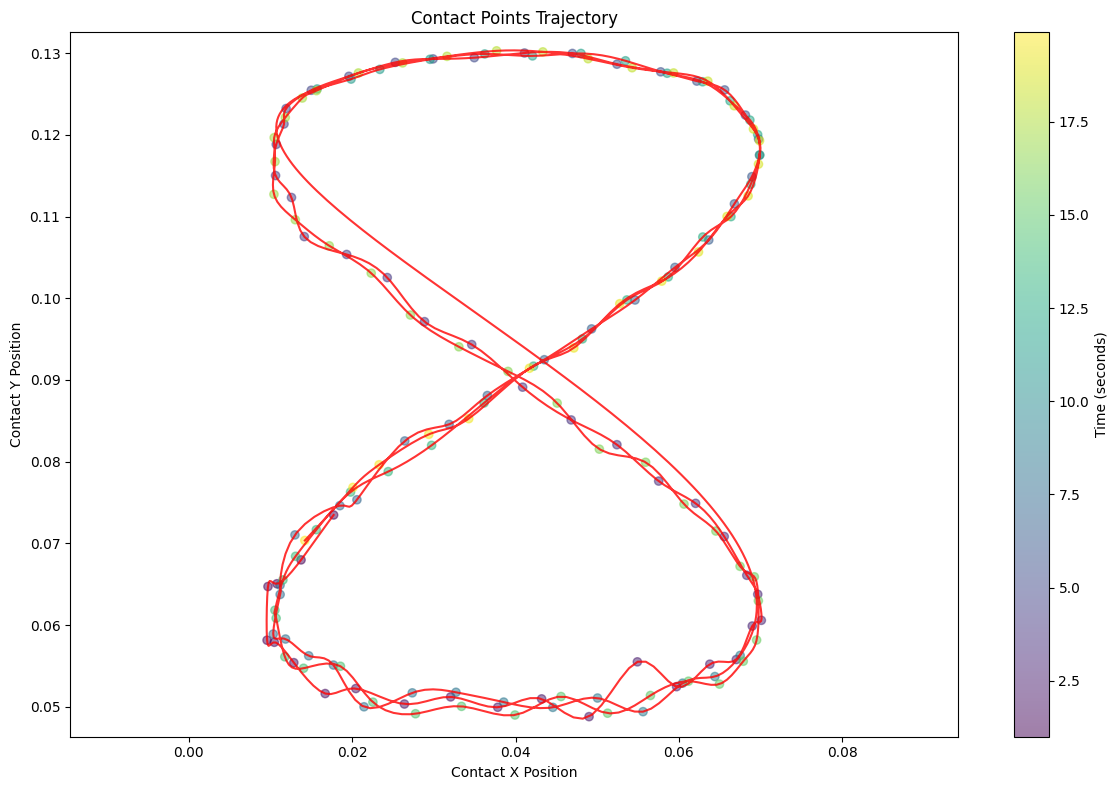

In [7]:
# Create visualization of contact points
plt.figure(figsize=(12, 8))

plt.plot(x_interp, y_interp, color='red', alpha=0.8)
plt.scatter(df['contact_x'], df['contact_y'], alpha=0.5, c=df['time_relative'], cmap='viridis')
plt.colorbar(label='Time (seconds)')
plt.xlabel('Contact X Position')
plt.ylabel('Contact Y Position')
plt.title('Contact Points Trajectory')
plt.axis('equal')

plt.tight_layout()
plt.show()

In [8]:
def convert_to_grid(x_coords, y_coords, forces=None, grid_size=28, line_thickness=1):

    # Normalize coordinates to [0, grid_size-1]
    x_min, x_max = x_coords.min(), x_coords.max()
    y_min, y_max = y_coords.min(), y_coords.max()

    # Add small padding to ensure points at edges are included
    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1

    x_min -= x_padding
    x_max += x_padding
    y_min -= y_padding
    y_max += y_padding
    
    x_normalized = ((x_coords - x_min) / (x_max - x_min) * (grid_size - 1))
    y_normalized = ((y_coords - y_min) / (y_max - y_min) * (grid_size - 1))
    
    # Create empty grid
    grid = np.zeros((grid_size, grid_size))
    
    # Convert coordinates to integer indices
    x_indices = x_normalized.round().astype(int)
    y_indices = y_normalized.round().astype(int)
    
    # Draw trajectory with thickness
    for i in range(len(x_indices)-1):
        # Get current and next point
        x1, y1 = x_indices[i], y_indices[i]
        x2, y2 = x_indices[i+1], y_indices[i+1]
        
        # Interpolate points between current and next point
        num_steps = max(abs(x2-x1), abs(y2-y1)) * 2
        if num_steps > 0:
            xs = np.linspace(x1, x2, num_steps+1)
            ys = np.linspace(y1, y2, num_steps+1)
            
            # Draw thick line by filling neighboring pixels
            for x, y in zip(xs, ys):
                x, y = int(round(x)), int(round(y))
                for dx in range(-line_thickness, line_thickness+1):
                    for dy in range(-line_thickness, line_thickness+1):
                        if 0 <= x+dx < grid_size and 0 <= y+dy < grid_size:
                            grid[y+dy, x+dx] = 1
    
    return grid

In [9]:
# Convert to grid with different line thicknesses
grids = {
    'thin': convert_to_grid(x_interp, y_interp, line_thickness=0),
    'medium': convert_to_grid(x_interp, y_interp, line_thickness=1),
    'thick': convert_to_grid(x_interp, y_interp, line_thickness=2)
}

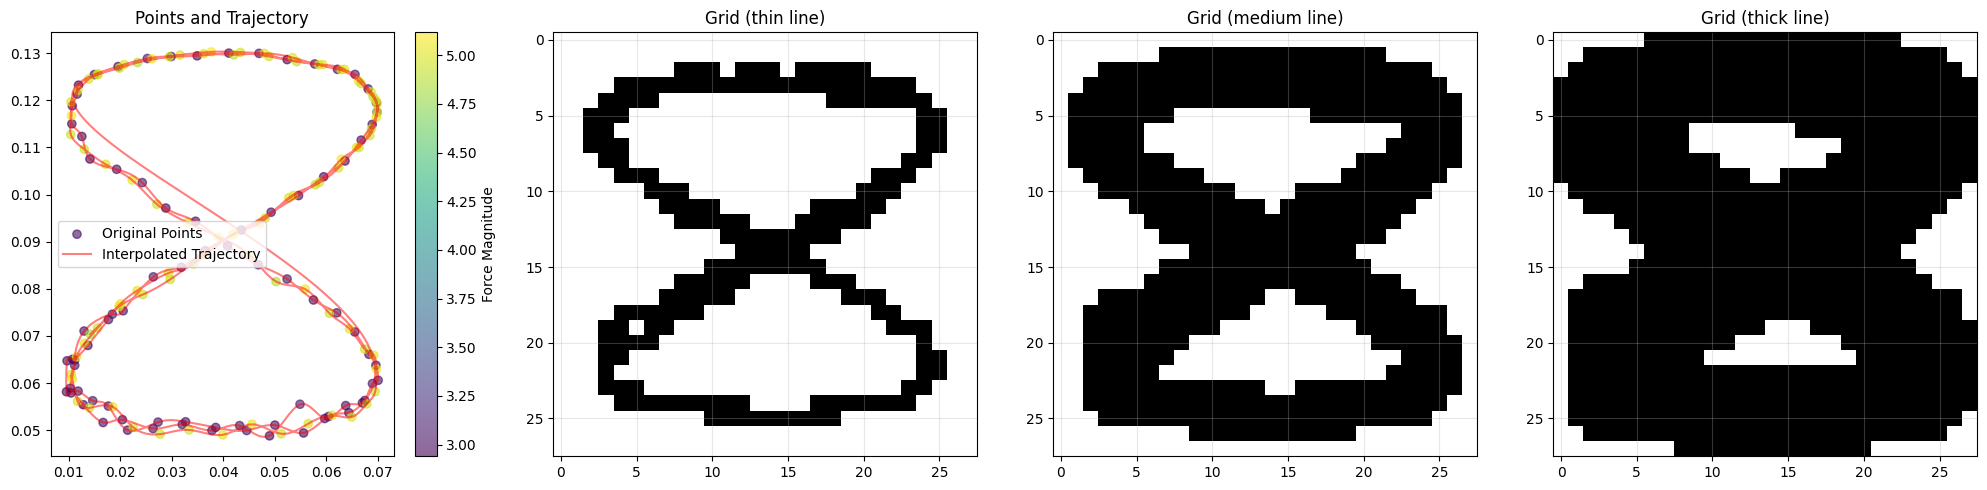


Grid Statistics (thin line):
Non-zero cells: 185 out of 784
Coverage: 23.60%

Grid Statistics (medium line):
Non-zero cells: 428 out of 784
Coverage: 54.59%

Grid Statistics (thick line):
Non-zero cells: 643 out of 784
Coverage: 82.02%


In [10]:
# Visualize results
plt.figure(figsize=(20, 5))

# Original points and interpolated trajectory
plt.subplot(141)
plt.scatter(df['contact_x'], df['contact_y'], 
           c=df['force_magnitude'], cmap='viridis', alpha=0.6, label='Original Points')
plt.plot(x_interp, y_interp, 'r-', alpha=0.5, label='Interpolated Trajectory')
plt.colorbar(label='Force Magnitude')
plt.title('Points and Trajectory')
plt.legend()

# Show different line thicknesses
for i, (thickness, grid) in enumerate(grids.items(), 2):
    plt.subplot(1, 4, i)
    plt.imshow(grid, cmap='gray_r')
    plt.title(f'Grid ({thickness} line)')
    plt.axis('on')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print grid statistics
for thickness, grid in grids.items():
    print(f"\nGrid Statistics ({thickness} line):")
    print(f"Non-zero cells: {np.count_nonzero(grid)} out of {grid.size}")
    print(f"Coverage: {np.count_nonzero(grid)/grid.size*100:.2f}%")

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [12]:
model = Net()
model.load_state_dict(torch.load('../../model/mnist_cnn.pth'))
model.eval()
# If CUDA is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to device: {device}")

/tmp/ipykernel_57776/88159534.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../model/mnist_cnn.pth'))


Model moved to device: cuda


In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class TrajectoryRecognizer:
    def __init__(self, model_path):
        """
        Initialize the recognizer with a trained model
        
        Args:
            model_path (str): Path to the trained PyTorch model
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = Net()
        self.model.load_state_dict(torch.load(model_path))
        print(f"Model moved to device: {self.device}")
        self.model.to(self.device)
        self.model.eval()
        
        # Define preprocessing transforms to match MNIST format
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization values
        ])
    
    def preprocess_trajectory(self, df, force_threshold=0.5, num_interpolation_points=1000, line_thickness=1):
        """
        Preprocess trajectory data into MNIST-like format
        """
        # Filter by force magnitude
        df['force_magnitude'] = np.sqrt(df['force_x']**2 + df['force_y']**2 + df['force_z']**2)
        df_filtered = df[df['force_magnitude'] >= force_threshold].copy()
        
        if len(df_filtered) == 0:
            raise ValueError("No points remain after force threshold filtering")
            
        # Interpolate trajectory
        times = df_filtered['timestamp'].values
        x = df_filtered['contact_x'].values
        y = df_filtered['contact_y'].values
        
        t_new = np.linspace(times.min(), times.max(), num_interpolation_points)
        x_interp = np.interp(t_new, times, x)
        y_interp = np.interp(t_new, times, y)
        
        # Convert to grid
        grid = self.trajectory_to_grid(x_interp, y_interp, line_thickness)
        
        # Convert to tensor format
        tensor_image = self.transform(grid.astype(np.float32))
        tensor_image = tensor_image.to(self.device)
        
        # Return all intermediate results for visualization
        preprocessing_data = {
            'df_filtered': df_filtered,
            'x_interp': x_interp,
            'y_interp': y_interp,
            't_new': t_new,
            'times': times
        }
        
        return grid, tensor_image, preprocessing_data
    
    def trajectory_to_grid(self, x_coords, y_coords, line_thickness=1, grid_size=28):
        """
        Convert trajectory coordinates to grid format
        """
        # Normalize coordinates with padding
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()

        # Add small padding to ensure points at edges are included
        x_padding = (x_max - x_min) * 0.1
        y_padding = (y_max - y_min) * 0.1

        x_min -= x_padding
        x_max += x_padding
        y_min -= y_padding
        y_max += y_padding
        
        x_normalized = ((x_coords - x_min) / (x_max - x_min) * (grid_size - 1))
        y_normalized = ((y_coords - y_min) / (y_max - y_min) * (grid_size - 1))
        
        grid = np.zeros((grid_size, grid_size))
        
        # Draw trajectory with thickness
        for i in range(len(x_normalized)-1):
            x1, y1 = int(round(x_normalized[i])), int(round(y_normalized[i]))
            x2, y2 = int(round(x_normalized[i+1])), int(round(y_normalized[i+1]))
            
            # Interpolate between points
            num_steps = max(abs(x2-x1), abs(y2-y1)) * 2
            if num_steps > 0:
                xs = np.linspace(x1, x2, num_steps+1)
                ys = np.linspace(y1, y2, num_steps+1)
                
                for x, y in zip(xs, ys):
                    x, y = int(round(x)), int(round(y))
                    for dx in range(-line_thickness, line_thickness+1):
                        for dy in range(-line_thickness, line_thickness+1):
                            if 0 <= x+dx < grid_size and 0 <= y+dy < grid_size:
                                grid[y+dy, x+dx] = 1
        
        return grid
    
    def predict(self, tensor_image):
        """
        Make prediction using the model
        """
        with torch.no_grad():
            # Add batch dimension
            input_tensor = tensor_image.unsqueeze(0)
            
            # Get model prediction
            output = self.model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predicted_class = output.argmax(dim=1).item()
            confidence = probabilities[0][predicted_class].item()
            
            # Get top-3 predictions
            top3_prob, top3_indices = torch.topk(probabilities, 3)
            top3_predictions = [(idx.item(), prob.item()) 
                              for idx, prob in zip(top3_indices[0], top3_prob[0])]
            
        return predicted_class, confidence, top3_predictions

    def visualize_complete_process(self, df_original, grid, preprocessing_data, 
                                 predicted_class, confidence, top3_predictions):
        """
        Visualize the complete preprocessing and recognition process
        """
        fig = plt.figure(figsize=(20, 10))
        
        # 1. Original data with force magnitude
        ax1 = plt.subplot(231)
        scatter = ax1.scatter(df_original['contact_x'], df_original['contact_y'], 
                            c=df_original['force_magnitude'], cmap='viridis', alpha=0.6)
        plt.colorbar(scatter, ax=ax1, label='Force Magnitude')
        ax1.set_title('Original Data')
        ax1.set_xlabel('X Position')
        ax1.set_ylabel('Y Position')
        
        # 2. Filtered data
        ax2 = plt.subplot(232)
        df_filtered = preprocessing_data['df_filtered']
        scatter = ax2.scatter(df_filtered['contact_x'], df_filtered['contact_y'],
                            c=df_filtered['force_magnitude'], cmap='viridis', alpha=0.6)
        plt.colorbar(scatter, ax=ax2, label='Force Magnitude')
        ax2.set_title('Filtered Data')
        ax2.set_xlabel('X Position')
        ax2.set_ylabel('Y Position')
        
        # 3. Interpolated trajectory
        ax3 = plt.subplot(233)
        ax3.plot(preprocessing_data['x_interp'], preprocessing_data['y_interp'], 
                'b-', label='Interpolated', alpha=0.7)
        ax3.scatter(df_filtered['contact_x'], df_filtered['contact_y'],
                   c='red', alpha=0.4, s=30, label='Original Points')
        ax3.set_title('Interpolated Trajectory')
        ax3.set_xlabel('X Position')
        ax3.set_ylabel('Y Position')
        ax3.legend()
        
        # 4. Final grid
        ax4 = plt.subplot(234)
        ax4.imshow(grid, cmap='gray_r')
        ax4.set_title('Grid Representation')
        ax4.grid(True, alpha=0.3)
        
        # 5. Prediction results
        ax5 = plt.subplot(235)
        ax5.axis('off')
        prediction_text = [
            f'Predicted Digit: {predicted_class}',
            f'Confidence: {confidence:.2%}',
            '\nTop 3 Predictions:'
        ]
        for digit, prob in top3_predictions:
            prediction_text.append(f'{digit}: {prob:.2%}')
        
        ax5.text(0.1, 0.6, '\n'.join(prediction_text), fontsize=12)
        ax5.set_title('Recognition Results')
        
        # 6. Time series plot
        ax6 = plt.subplot(236)
        times = preprocessing_data['times']
        t_new = preprocessing_data['t_new']
        ax6.plot(t_new - t_new[0], preprocessing_data['x_interp'], 
                'b-', label='X interpolated', alpha=0.7)
        ax6.plot(t_new - t_new[0], preprocessing_data['y_interp'], 
                'r-', label='Y interpolated', alpha=0.7)
        ax6.scatter(times - times[0], df_filtered['contact_x'], 
                   c='blue', alpha=0.4, s=30, label='X original')
        ax6.scatter(times - times[0], df_filtered['contact_y'], 
                   c='red', alpha=0.4, s=30, label='Y original')
        ax6.set_title('Position vs Time')
        ax6.set_xlabel('Time (s)')
        ax6.set_ylabel('Position')
        ax6.legend()
        
        plt.tight_layout()
        plt.show()

def recognize_trajectory(data_file, model_path):
    """
    Process trajectory data and recognize the digit
    """
    try:
        # Initialize recognizer
        recognizer = TrajectoryRecognizer(model_path)
        
        # Load data
        df = pd.read_csv(data_file)
        
        # Preprocess trajectory
        grid, tensor_image, preprocessing_data = recognizer.preprocess_trajectory(df)
        
        # Get prediction
        predicted_class, confidence, top3_predictions = recognizer.predict(tensor_image)
        
        # Visualize complete process
        recognizer.visualize_complete_process(df, grid, preprocessing_data,
                                           predicted_class, confidence, top3_predictions)
        
        return predicted_class, confidence, top3_predictions
        
    except Exception as e:
        print(f"Error in recognition process: {e}")
        raise


/tmp/ipykernel_57776/2892813311.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


Model moved to device: cuda


/home/rayann/miniconda3/envs/viz_env/lib/python3.11/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


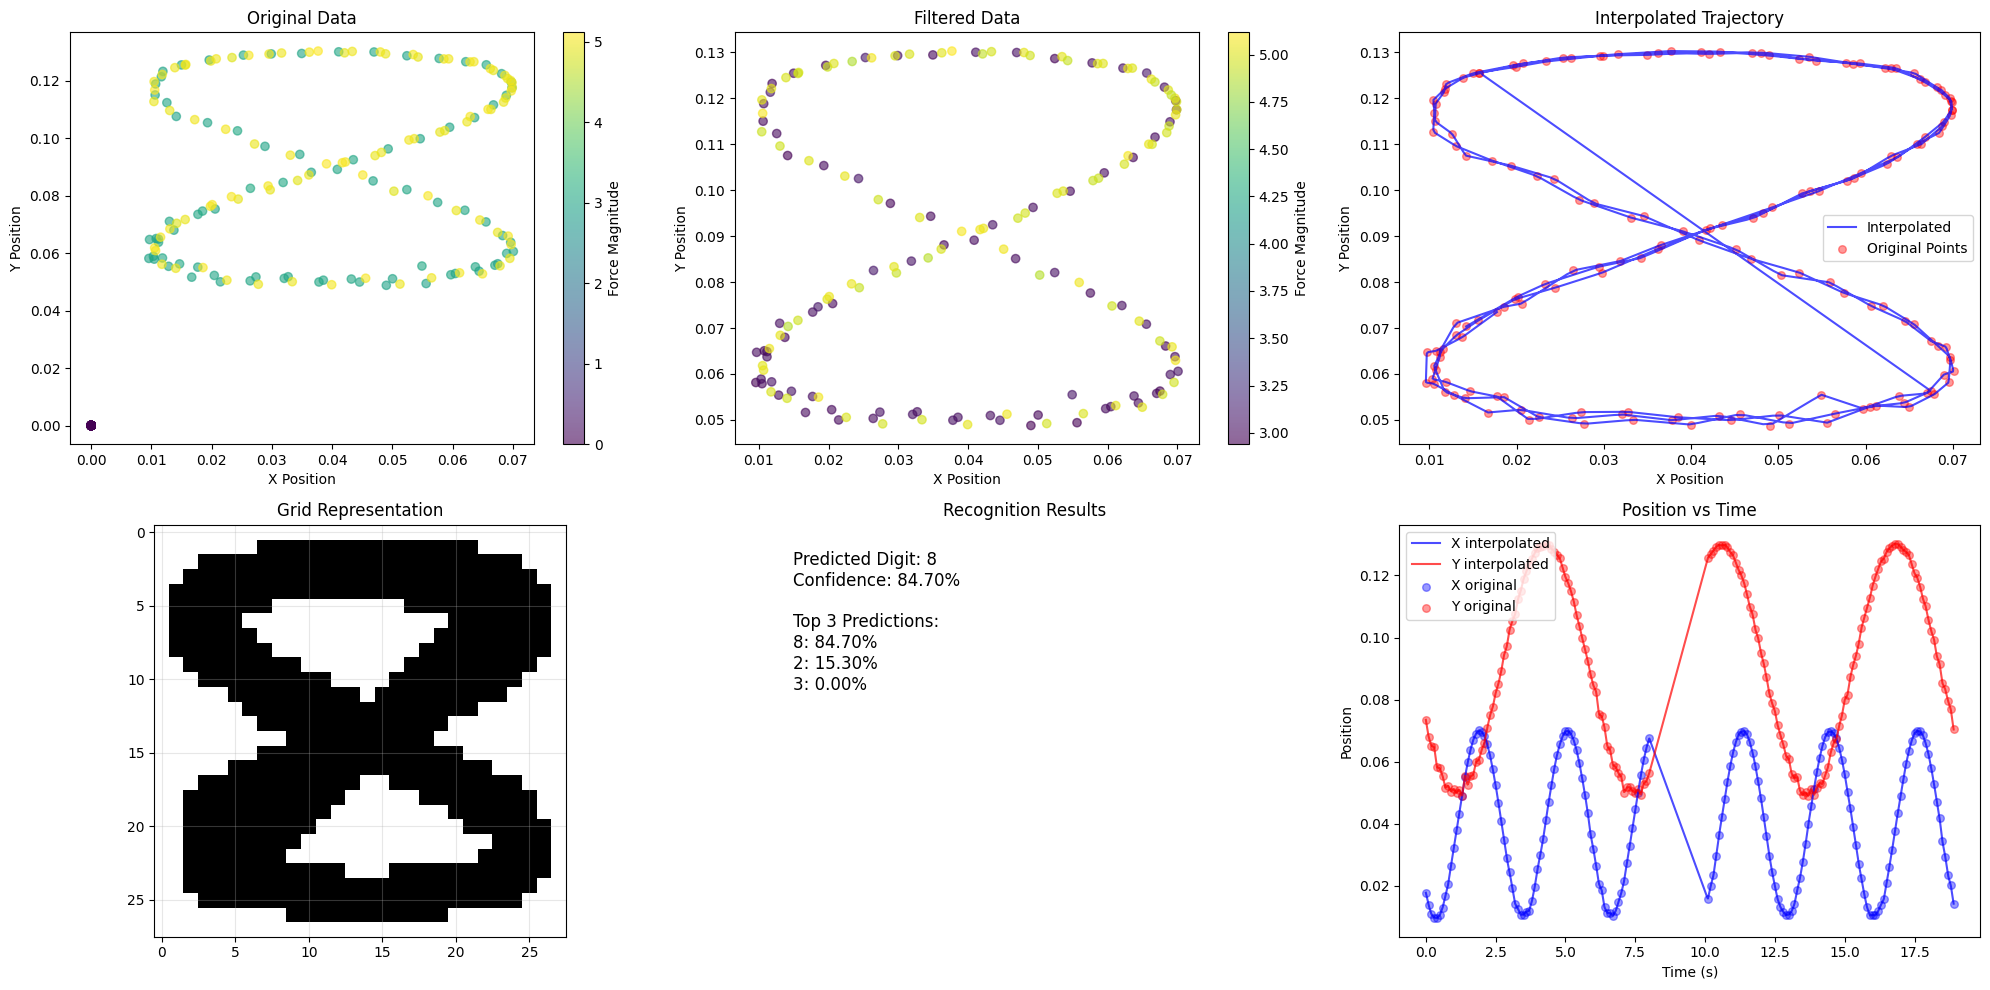

In [14]:
model_path = '../../model/mnist_cnn.pth'
data_file = '../../data/raw/ft_data_simulated.csv'
predicted_digit, confidence, top3 = recognize_trajectory(data_file, model_path)